# Importing Required Libraries 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import os

2024-07-06 05:36:16.987529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 05:36:16.987578: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 05:36:16.989185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset directories

In [2]:
# Set the path to our dataset
base_dir = '/kaggle/input/vegetable-image-dataset/Vegetable Images'  
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# Image data generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

## Data visualization

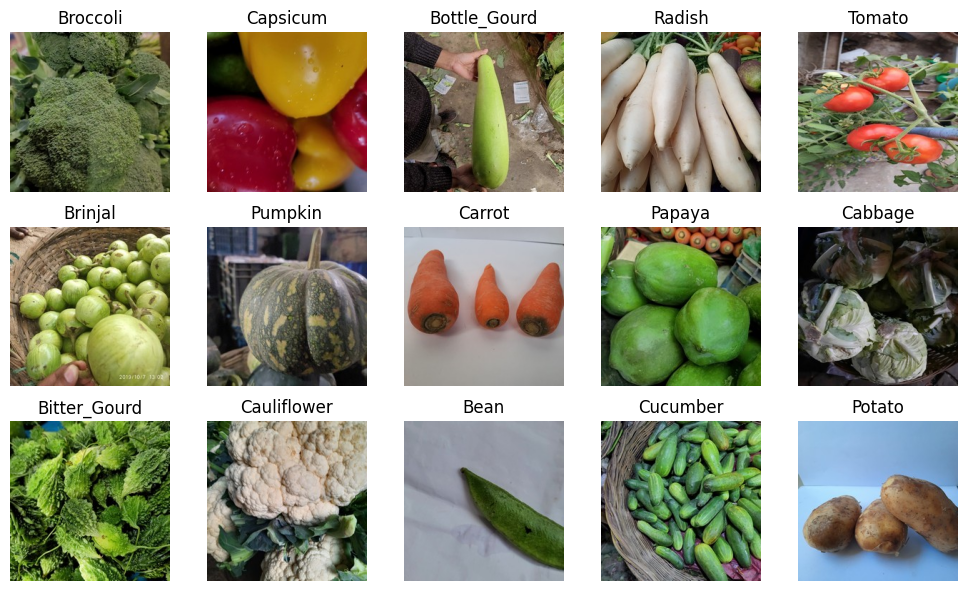

In [4]:
class_dirs = os.listdir(train_dir)

plt.figure(figsize=(10, 6))
for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(train_dir, class_dir)
    image_files = os.listdir(class_path)
    
    # Load the first image file
    image_path = os.path.join(class_path, image_files[0])
    image = mpimg.imread(image_path)
    
    # Plot the image
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.title(class_dir)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Frequency of images in every class 

In [5]:
# Function to count the number of images in each class directory
def count_images_in_directory(directory):
    class_counts = defaultdict(int)
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
    return class_counts

In [6]:
# Count the number of images in each class for train, validation, and test sets
train_counts = count_images_in_directory(train_dir)
validation_counts = count_images_in_directory(validation_dir)
test_counts = count_images_in_directory(test_dir)


In [7]:
# Print number of images per class in a tabular form
print("Number of images per class:")
print("Training dataset:")
for cls, count in train_counts.items():
    print(f"{cls}: {count}")

print("\nValidation dataset:")
for cls, count in validation_counts.items():
    print(f"{cls}: {count}")

print("\nTest dataset:")
for cls, count in test_counts.items():
    print(f"{cls}: {count}")

Number of images per class:
Training dataset:
Broccoli: 1000
Capsicum: 1000
Bottle_Gourd: 1000
Radish: 1000
Tomato: 1000
Brinjal: 1000
Pumpkin: 1000
Carrot: 1000
Papaya: 1000
Cabbage: 1000
Bitter_Gourd: 1000
Cauliflower: 1000
Bean: 1000
Cucumber: 1000
Potato: 1000

Validation dataset:
Broccoli: 200
Capsicum: 200
Bottle_Gourd: 200
Radish: 200
Tomato: 200
Brinjal: 200
Pumpkin: 200
Carrot: 200
Papaya: 200
Cabbage: 200
Bitter_Gourd: 200
Cauliflower: 200
Bean: 200
Cucumber: 200
Potato: 200

Test dataset:
Broccoli: 200
Capsicum: 200
Bottle_Gourd: 200
Radish: 200
Tomato: 200
Brinjal: 200
Pumpkin: 200
Carrot: 200
Papaya: 200
Cabbage: 200
Bitter_Gourd: 200
Cauliflower: 200
Bean: 200
Cucumber: 200
Potato: 200


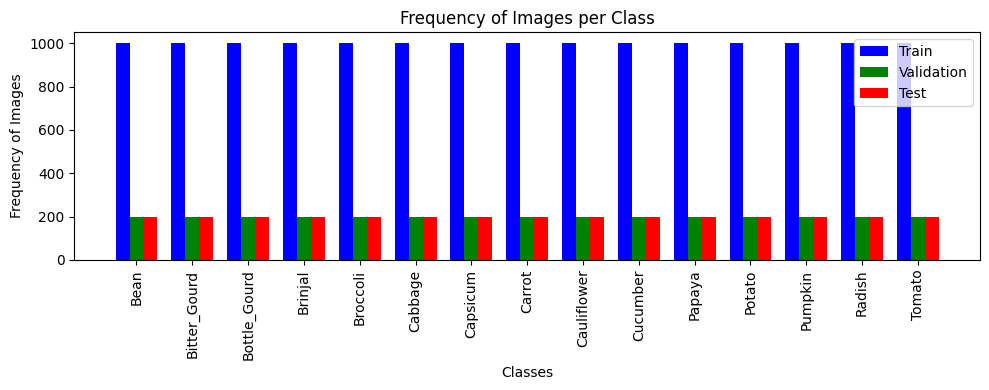

In [8]:
labels = sorted(train_counts.keys())

train_values = [train_counts[cls] for cls in labels]
validation_values = [validation_counts[cls] for cls in labels]
test_values = [test_counts[cls] for cls in labels]

x = np.arange(len(labels)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(10, 4))

rects1 = ax.bar(x - width, train_values, width, label='Train', color='b')
rects2 = ax.bar(x, validation_values, width, label='Validation', color='g')
rects3 = ax.bar(x + width, test_values, width, label='Test', color='r')

ax.set_xlabel('Classes')
ax.set_ylabel('Frequency of Images')
ax.set_title('Frequency of Images per Class')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

fig.tight_layout()

plt.show()

# Load Data

In [9]:
# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [10]:
# Get class indices and labels mapping
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

# Customized CNN model

In [11]:
model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    15,860,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,290,639 (62.14 MB)

 Trainable params: 16,290,639 (62.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Custom callback for logging early stopping
class EarlyStoppingAlert(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if self.model.stop_training:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")

In [15]:
# Callbacks for early stopping, learning rate reduction, and saving the best model
checkpoint = ModelCheckpoint('veg_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stopping_alert = EarlyStoppingAlert()

In [16]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr, early_stopping_alert]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/468 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.1172 - loss: 2.7037   

I0000 00:00:1720244208.821894    1114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720244208.842055    1114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


260/468 ━━━━━━━━━━━━━━━━━━━━ 31s 150ms/step - accuracy: 0.2647 - loss: 2.1805

W0000 00:00:1720244247.707338    1114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3481 - loss: 1.9365

W0000 00:00:1720244261.750312    1114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


468/468 ━━━━━━━━━━━━━━━━━━━━ 75s 126ms/step - accuracy: 0.3484 - loss: 1.9356 - val_accuracy: 0.7688 - val_loss: 0.7472 - learning_rate: 1.0000e-04
Epoch 2/50
  1/468 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.7188 - loss: 0.7701

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7188 - loss: 0.7701 - val_accuracy: 0.6250 - val_loss: 1.0148 - learning_rate: 1.0000e-04
Epoch 3/50


W0000 00:00:1720244268.325621    1113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


468/468 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.7512 - loss: 0.7659 - val_accuracy: 0.8787 - val_loss: 0.4051 - learning_rate: 1.0000e-04
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.6521 - val_accuracy: 0.9167 - val_loss: 0.2991 - learning_rate: 1.0000e-04
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.8455 - loss: 0.4868 - val_accuracy: 0.9096 - val_loss: 0.3022 - learning_rate: 1.0000e-04
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 74us/step - accuracy: 0.7812 - loss: 0.6707 - val_accuracy: 0.9167 - val_loss: 0.2715 - learning_rate: 1.0000e-04
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.8901 - loss: 0.3458 - val_accuracy: 0.9251 - val_loss: 0.2610 - learning_rate: 1.0000e-04
Epoch 8/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.7812 - loss: 0.5053 - val_accuracy: 0.9167 - val_loss: 0.2857 - learning_rate: 1.0000e-04
Epoch 9/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0

## Training loss x Validation Loss
## Training Accuracy x Validation Accuracy

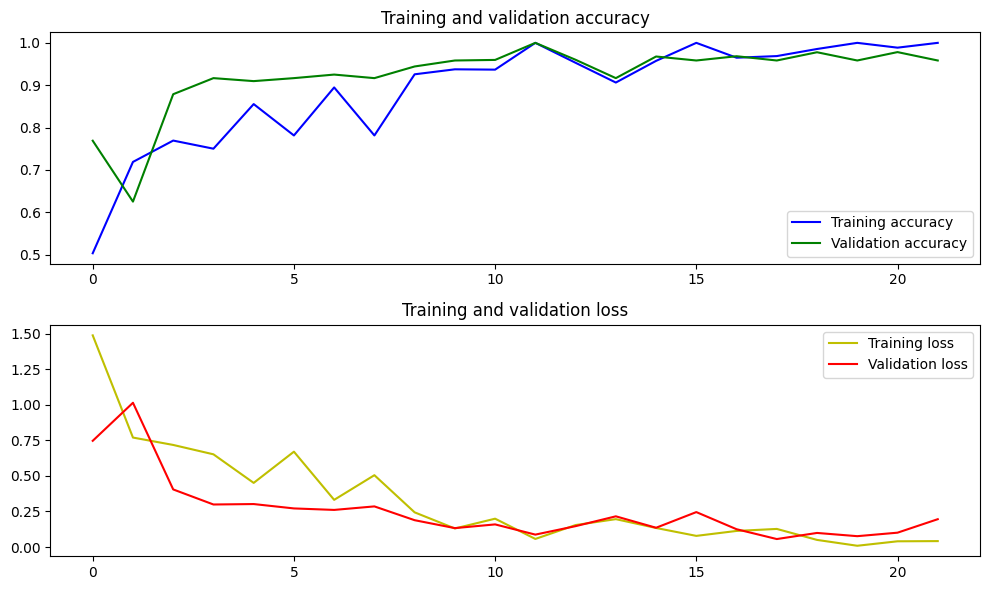

In [17]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, 'y-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.tight_layout()
plt.show()

## Make Prediction on the Test Dataset

In [18]:
# Predict on test data
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

 4/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step 

W0000 00:00:1720244614.967125    1113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step


W0000 00:00:1720244620.640268    1115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Model Evaluation and Result

In [19]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

        Bean       0.96      0.99      0.98       200
Bitter_Gourd       0.99      0.98      0.99       200
Bottle_Gourd       0.99      1.00      0.99       200
     Brinjal       1.00      0.97      0.99       200
    Broccoli       0.98      0.96      0.97       200
     Cabbage       0.94      0.98      0.96       200
    Capsicum       0.99      0.98      0.99       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.95      0.96      0.96       200
    Cucumber       0.99      0.97      0.98       200
      Papaya       0.97      0.99      0.98       200
      Potato       1.00      1.00      1.00       200
     Pumpkin       0.98      0.95      0.96       200
      Radish       0.99      0.99      0.99       200
      Tomato       0.98      0.94      0.96       200

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98   

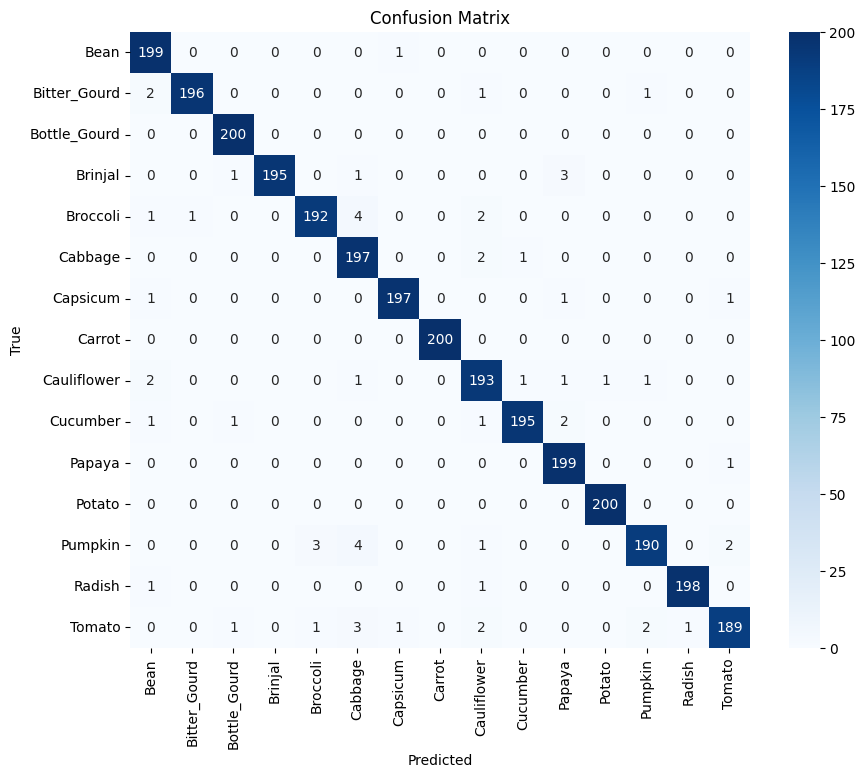

In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [21]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc*100:.2f}%')

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.9856 - loss: 0.0692
Test accuracy: 97.98%
